# PyFina

## Object

In [92]:
from __future__ import annotations
import logging
import math
import os
import struct

from typing import Literal

import numpy as np

logging.basicConfig()
pyfina_logger = logging.getLogger(__name__)


def trim(feed_id: int, data_dir: str, limit: int = 100) -> None:
    """
    checks and removes anomalies (values above a threshold limit, eg 100)
    feed_id: feed number
    data_dir: feed path (eg /var/opt/emoncms/phpfina)
    limit: threshold we don't want to exceed
    """
    meta = getMeta(feed_id, data_dir)
    if not meta:
        return
    pos = 0
    i = 0
    nbn = 0
    with open(f"{data_dir}/{feed_id}.dat", "rb+") as ts:
        while pos <= meta["npoints"]:
            ts.seek(pos * 4, 0)
            hexa = ts.read(4)
            aa = bytearray(hexa)
            if len(aa) == 4:
                value = struct.unpack("<f", aa)[0]
                if math.isnan(value):
                    nbn += 1
                elif value > limit:
                    message = f"anomaly detected at {pos} : {value}"
                    pyfina_logger.debug(message)
                    i += 1
                    nv = struct.pack("<f", float("nan"))
                    try:
                        ts.seek(pos * 4, 0)
                        ts.write(nv)
                    except Exception as e:
                        pyfina_logger.error(e)
                    finally:
                        pyfina_logger.debug("4 bytes written")
            pos += 1
        message = f"{i} anomaly(ies)"
        pyfina_logger.debug(message)
        message = f"{nbn} nan"
        pyfina_logger.debug(message)


def getMeta(feed_id: int, data_dir: str) -> Literal[False] | dict[str, int]:
    """
    decoding the .meta file
    feed_id (4 bytes, Unsigned integer)
    npoints (4 bytes, Unsigned integer, Legacy : use instead filesize//4 )
    interval (4 bytes, Unsigned integer)
    start_time (4 bytes, Unsigned integer)
    """
    with open(f"{data_dir}/{feed_id}.meta", "rb") as f:
        f.seek(8, 0)
        hexa = f.read(8)
        aa = bytearray(hexa)
        if len(aa) == 8:
            decoded = struct.unpack("<2I", aa)
        else:
            pyfina_logger.error("corrupted meta - aborting")
            return False
    meta = {
        "interval": decoded[0],
        "start_time": decoded[1],
        "npoints": os.path.getsize(f"{data_dir}/{feed_id}.dat") // 4,
    }
    meta['end_time'] = meta['start_time'] + (meta['npoints'] * meta['interval']) - meta['interval']
    return meta

class PyFina(np.ndarray):
    """pyfina class."""
    start: int | None = None
    step: int | None = None
    nb_nan: int | None = None
    first_non_nan_value: float | None = None
    first_non_nan_index: int | None = None
    starting_by_nan : bool | None = None

    def __new__(
        cls,
        feed_id: int,
        data_dir: str,
        start: int,
        step: int,
        npts: int,
        remove_nan: bool = True,
    ):
        meta = getMeta(feed_id, data_dir)
        if not meta:
            return None
        # decoding and sampling the .dat file
        # values are 32 bit floats, stored on 4 bytes
        # to estimate value(time), position in the dat file is calculated as follow :
        # pos = (time - meta["start_time"]) // meta["interval"]
        # Nota : if remove_nan is True and a NAN is detected, the algorithm takes previous value
        obj = super().__new__(cls, shape=(npts,))
        obj.fill(np.nan)
        pyfina_logger.debug(obj)
        raw_obj = np.empty(npts)
        raw_obj.fill(np.nan)
        end = start + (npts - 1) * step
        time = start
        if time >= meta['end_time']:
            raise ValueError("Error: invalid start value, "
                             "start must be upper than end time value "
                             "defined by start_time + (npoints * interval) from meta."
                            )
        i = 0
        nb_nan = 0
        with open(f"{data_dir}/{feed_id}.dat", "rb") as ts:
            while time < end:
                time = start + step * i
                pos = (time - meta["start_time"]) // meta["interval"]
                if 0 <= pos < meta["npoints"]:
                    try:
                        # message = f"trying to find point {i} going to index {pos}"
                        # pyfina_logger.debug(message)
                        ts.seek(pos * 4, 0)
                        hexa = ts.read(4)
                        aa = bytearray(hexa)
                    except Exception as e:
                        message = f"error during file operation {e}"
                        pyfina_logger.error(message)
                    else:
                        if len(aa) == 4:
                            value = struct.unpack("<f", aa)[0]
                            obj[i] = value
                            raw_obj[i] = value
                            if remove_nan and np.isnan(value):
                                nb_nan += 1
                                obj[i] = obj[i - 1]
                        else:
                            message = f"unpacking problem {i} len is {len(aa)} position is {pos}"
                            pyfina_logger.error(message)
                else:
                    time = end
                i += 1
        first_non_nan_value = -1
        first_non_nan_index = -1
        starting_by_nan = np.isnan(raw_obj[0])
        if nb_nan < npts:
            finiteness_obj = np.isfinite(raw_obj)
            if finiteness_obj.sum() > 0:
                first_non_nan_index = np.where(finiteness_obj)[0][0]
                first_non_nan_value = raw_obj[finiteness_obj][0]
                if starting_by_nan and remove_nan:
                    obj[:first_non_nan_index] = (
                        np.ones(first_non_nan_index) * first_non_nan_value
                    )
        # storing the "signature" of the "sampled" feed
        obj.start = start
        obj.step = step
        obj.nb_nan = nb_nan
        obj.first_non_nan_value = first_non_nan_value
        obj.first_non_nan_index = first_non_nan_index
        obj.starting_by_nan = starting_by_nan
        return obj

    def timescale(self):
        """
        return the time scale of the feed as a numpy array
        """
        return np.arange(0, self.step * self.shape[0], self.step)

## Test

### Imports

In [12]:
import datetime
import os
import time
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from IPython.display import display
from multigraph import check_starting_nan

### Test 1

{'interval': 10, 'start_time': 1575981140, 'npoints': 4551863}
température extérieure : 38 nan in the feed


C:\Users\mexse\AppData\Local\Temp\ipykernel_52284\1106623605.py:20: DeprecationWarning: datetime.datetime.utcfromtimestamp() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.fromtimestamp(timestamp, datetime.UTC).
  utcstart = datetime.datetime.utcfromtimestamp(start)


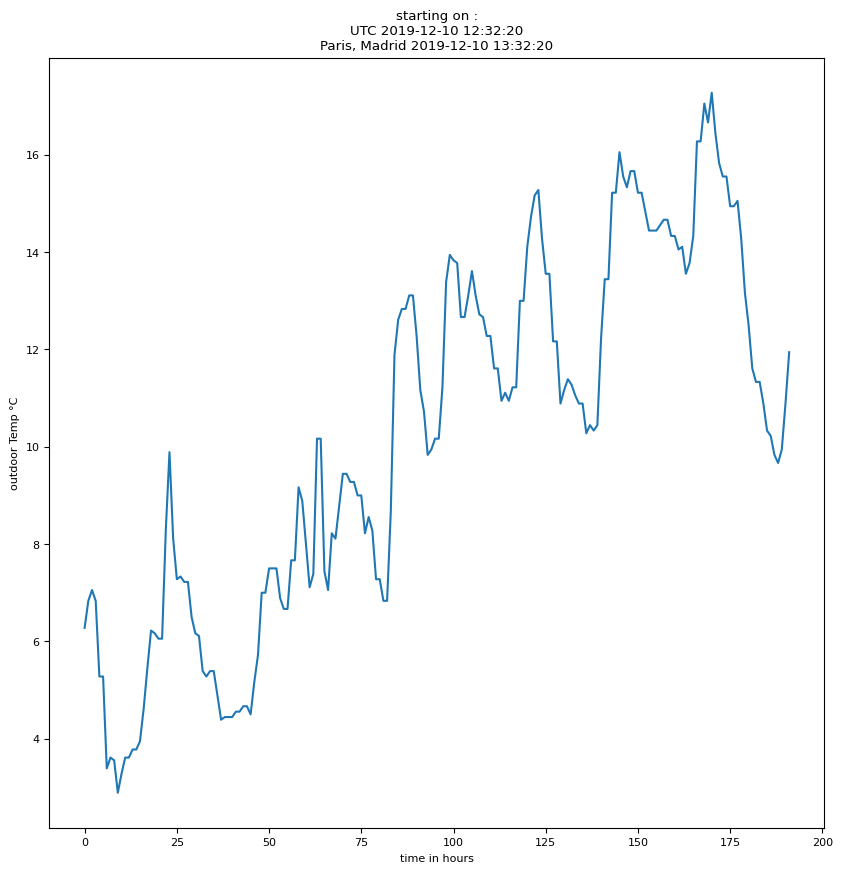

In [13]:
FEED_NB = 1
DATA_DIR = os.path.join(
    os.path.abspath(os.getcwd()),
    # "tests",
    "datas"
)
meta = getMeta(FEED_NB, DATA_DIR)
print(meta)
STEP = 3600
start = meta["start_time"]
length = meta["npoints"] * meta["interval"]
WINDOW = min(8 * 24 * 3600, length)

nbpts = WINDOW // STEP
temp_ext = PyFina(FEED_NB, DATA_DIR, start, STEP, nbpts)

check_starting_nan("température extérieure", temp_ext)

localstart = datetime.datetime.fromtimestamp(start)
utcstart = datetime.datetime.utcfromtimestamp(start)
title = f"starting on :\nUTC {utcstart}\n{time.tzname[0]} {localstart}"
figure = plt.figure(figsize = (10, 10))
matplotlib.rc('font', size=8)
plt.subplot(111)
plt.title(title)
plt.ylabel("outdoor Temp °C")
plt.xlabel("time in hours")
plt.plot(temp_ext)
figure.savefig(f"feed_{FEED_NB}.png")
plt.show()


### Test 2: empty array

{'interval': 1, 'start_time': 1538492746, 'npoints': 5011599}
température extérieure : 0 nan in the feed
first non nan value -1 at index -1


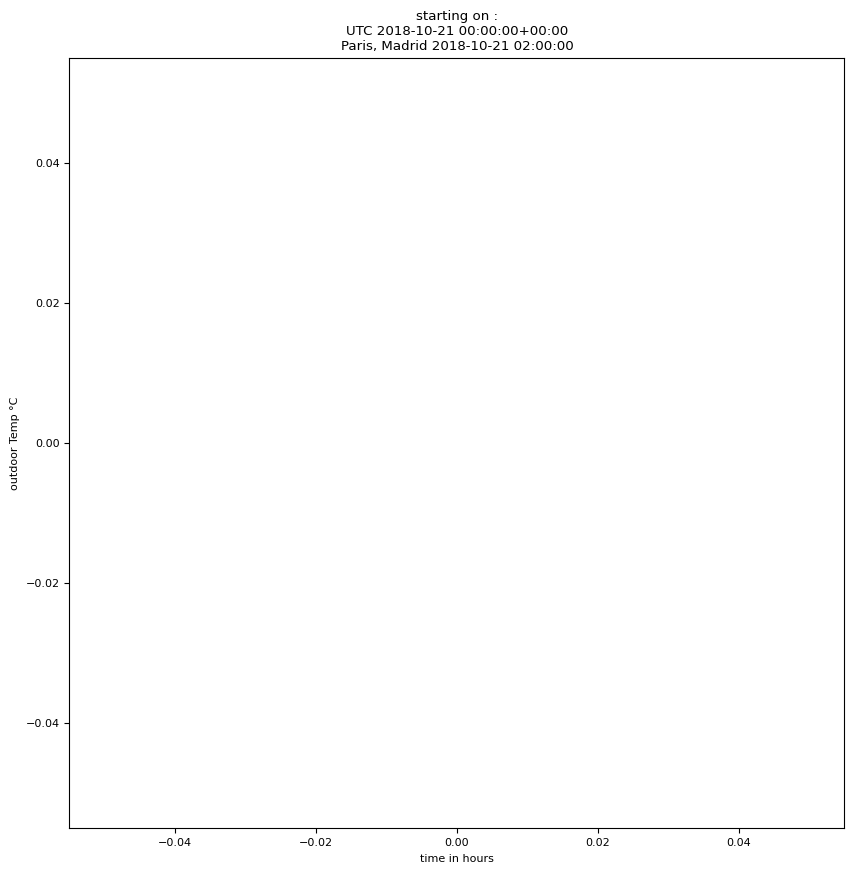

In [ ]:
FEED_NB = 2

meta = getMeta(FEED_NB, DATA_DIR)
print(meta)
STEP = 1
start = int(1540166400.0 - (3600 *24 * 1)) # + (8 * 3600) + (3600 / 2)) # 1542634200, 1542637800 1727276746
localstart = datetime.datetime.fromtimestamp(start)
utcstart = datetime.datetime.fromtimestamp(start, datetime.timezone.utc)
length = meta["npoints"] * meta["interval"]
WINDOW = min(24 * 3600, length)

nbpts = WINDOW // STEP
temp_ext = PyFina(FEED_NB, DATA_DIR, start, STEP, nbpts, remove_nan=False)

check_starting_nan("température extérieure", temp_ext)

title = f"starting on :\nUTC {utcstart}\n{time.tzname[0]} {localstart}"
figure = plt.figure(figsize = (10, 10))
matplotlib.rc('font', size=8)
plt.subplot(111)
plt.title(title)
plt.ylabel("outdoor Temp °C")
plt.xlabel("time in hours")
plt.plot(temp_ext)
figure.savefig(f"feed_{FEED_NB}.png")
plt.show()

### Test 3: Scan file

Feed Id: 2 file start at 2018-10-02 17:05:46 end at 2018-11-29 15:12:25+00:00
meta: {'interval': 1, 'start_time': 1538492746, 'npoints': 5011599, 'end_time': 1543504344}
Analysed 1460 Days in 3.2121125999838114s -- IO File Reads = 59
Global stats: 


,time,perf,lines,nb_finite,nb_nan,nb_valid,nb_inf
count,5.900000e+01,59.000000,59.0,59.000000,59.000000,59.000000,59.0
mean,1.540998e+09,1.637403,86400.0,7715.694915,78684.305085,7715.694915,0.0
std,1.483969e+06,0.934902,0.0,11044.275798,11044.275798,11044.275798,0.0
min,1.538493e+09,0.065007,86400.0,0.000000,50604.000000,0.000000,0.0
25%,1.539746e+09,0.852490,86400.0,0.000000,73140.500000,0.000000,0.0
50%,1.540998e+09,1.626940,86400.0,483.000000,85917.000000,483.000000,0.0
75%,1.542251e+09,2.426568,86400.0,13259.500000,86400.000000,13259.500000,0.0
max,1.543504e+09,3.189124,86400.0,35796.000000,86400.000000,35796.000000,0.0


,time,perf,lines,nb_finite,nb_nan,nb_valid,nb_inf,nanmin,nanmean,nanmax
index,,,,,,,,,,
2018-10-02 15:05:46+00:00,1538492746,0.065007,86400,18354,68046,18354,0,25.26799964904785,26.051037900001248,28.304000854492188
2018-10-03 15:05:46+00:00,1538579146,0.119669,86400,3964,82436,3964,0,26.628000259399414,27.42328505655591,28.520000457763672
2018-10-04 15:05:46+00:00,1538665546,0.173619,86400,941,85459,941,0,26.582000732421875,27.42080019992419,28.44700050354004
2018-10-05 15:05:46+00:00,1538751946,0.229688,86400,0,86400,0,0,NaN,NaN,NaN
2018-10-06 15:05:46+00:00,1538838346,0.282193,86400,2367,84033,2367,0,26.676000595092773,27.42406802223763,27.94700050354004
2018-10-07 15:05:46+00:00,1538924746,0.337798,86400,17645,68755,17645,0,25.58099937438965,27.352939146846644,28.628999710083008
2018-10-08 15:05:46+00:00,1539011146,0.391028,86400,34870,51530,34870,0,24.548999786376953,27.32949967101272,28.93400001525879
2018-10-09 15:05:46+00:00,1539097546,0.445812,86400,33067,53333,33067,0,25.479000091552734,27.209397055115176,29.92300033569336
2018-10-10 15:05:46+00:00,1539183946,0.502006,86400,13929,72471,13929,0,25.469999313354492,26.32814978813781,29.906999588012695


index
2018-10-05 15:05:46+00:00        0
2018-10-28 15:05:46+00:00        0
2018-10-31 15:05:46+00:00        0
2018-10-30 15:05:46+00:00        0
2018-11-01 15:05:46+00:00        0
2018-11-02 15:05:46+00:00        0
2018-10-22 15:05:46+00:00        0
2018-10-21 15:05:46+00:00        0
2018-10-29 15:05:46+00:00        0
2018-11-17 15:05:46+00:00        0
2018-11-16 15:05:46+00:00        0
2018-11-10 15:05:46+00:00        0
2018-11-07 15:05:46+00:00        0
2018-11-08 15:05:46+00:00        0
2018-11-27 15:05:46+00:00        0
2018-11-26 15:05:46+00:00        0
2018-11-19 15:05:46+00:00        0
2018-11-20 15:05:46+00:00        0
2018-11-21 15:05:46+00:00        0
2018-11-22 15:05:46+00:00        0
2018-11-24 15:05:46+00:00        0
2018-11-25 15:05:46+00:00        0
2018-11-15 15:05:46+00:00        0
2018-11-18 15:05:46+00:00        0
2018-11-11 15:05:46+00:00        0
2018-11-06 15:05:46+00:00        0
2018-11-09 15:05:46+00:00        0
2018-11-14 15:05:46+00:00       55
2018-11-29 15:

nb_valid
0        27
55        1
399       1
483       1
583       1
941       1
1133      1
2367      1
3964      1
7799      1
7801      1
8184      1
9413      1
9416      1
10653     1
11580     1
11639     1
12957     1
13562     1
13929     1
13939     1
15738     1
16192     1
17645     1
18354     1
19493     1
20526     1
32509     1
33067     1
34870     1
35043     1
35196     1
35796     1
Name: count, dtype: int64

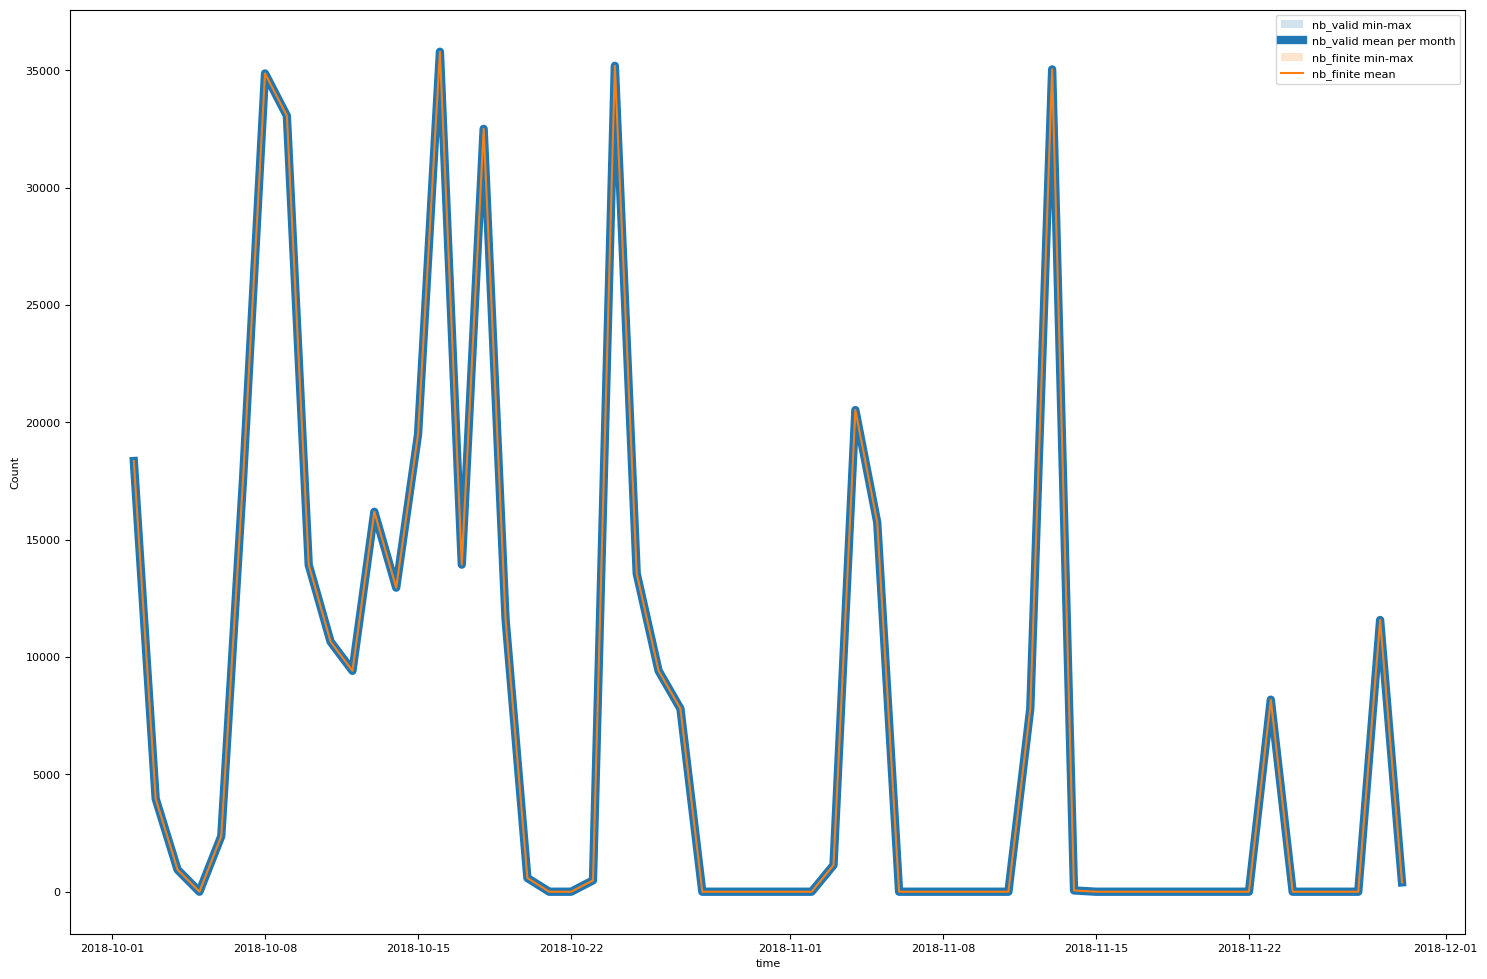

In [93]:
FEED_NB = 2
meta = getMeta(FEED_NB, DATA_DIR)
END_DATE = datetime.datetime.fromtimestamp(meta["start_time"] + meta["npoints"], tz=datetime.timezone.utc)
print(f"Feed Id: {FEED_NB} file start at {datetime.datetime.fromtimestamp(meta["start_time"])} end at {END_DATE}")
print(f"meta: {meta}")
STEP = int(1)
day_1 = datetime.datetime.fromtimestamp(meta["start_time"] + (24 * 3600), tz=datetime.timezone.utc)
# START_DAY = int(datetime.datetime(year=day_1.year, month=day_1.month, day=day_1.day, hour=0, minute=0, second=0, tzinfo=datetime.timezone.utc).timestamp())
# START_DAY = END_DATE.timestamp() + 3600 *24 * 31
START_DAY = meta["start_time"]
NB_DAYS = int(365 * 4)
DAY_S = 3600 * 24
start = meta["start_time"]
length = meta["npoints"] * meta["interval"]
WINDOW = min(DAY_S, length)

nbpts = WINDOW // STEP
timer_start = time.perf_counter()
stats = []
nb_io_read = 0
for i in range(0, NB_DAYS + 1):
    start_i = START_DAY + (DAY_S * i)
    if start_i >= meta["end_time"]:
        break
    # start_i = int(1727276746 - ((15 * 3600) + (3600 / 2)) + (NB_DAYS * 2))
    data = PyFina(FEED_NB, DATA_DIR, start_i, STEP, nbpts, remove_nan=False)
    # data = np.round(data, 3)
    nb_io_read += 1
    nb_valid = (20 < data) & (data < 40)
    nb_finite = int(np.isfinite(data).sum())
    nan_min, nan_mean, nan_max = np.nan, np.nan, np.nan
    if nb_finite > 0:
        nan_min = np.nanmin(data)
        nan_mean = np.nanmean(data)
        nan_max = np.nanmax(data)
    stats.append([
        start_i,
        time.perf_counter() - timer_start,
        data.shape[0],
        nb_finite,
        int(np.isnan(data).sum()),
        int(nb_valid.sum()),
        int(np.isinf(data).sum()),
        nan_min,
        nan_mean,
        nan_max
    ])

def desc_resampler(arraylike):
    print(arraylike.describe())
    return arraylike

if len(stats) > 0:
    df = pd.DataFrame(stats, columns=['time', 'perf', 'lines', 'nb_finite', 'nb_nan', 'nb_valid', 'nb_inf', 'nanmin', 'nanmean', 'nanmax'])
    df = df.set_index(pd.to_datetime(df['time'], unit='s', utc=True))
    df.index.name = 'index'
    print(f"Analysed {NB_DAYS} Days in {time.perf_counter() - timer_start}s -- IO File Reads = {nb_io_read}")
    print("Global stats: ")
    display(df.describe())
    display(df)
    display(df.sort_values('nb_valid')['nb_valid'])
    display(df.sort_values('nb_valid')['nb_valid'].value_counts())
    #print("Year stats: ")
    #print(df.resample('y').apply(desc_resampler))
    nb_valid_d = df['nb_valid'].resample('d').agg(['mean', 'std', 'min', 'max'])
    nb_finite_d = df['nb_finite'].resample('d').agg(['mean', 'std', 'min', 'max'])
    plt.figure(figsize = (18, 12))
    plt.subplot(1, 1, 1)
    plt.ylabel("Count")
    plt.xlabel("time")
    plt.fill_between(nb_valid_d.index, nb_valid_d['max'], nb_valid_d['min'], alpha=0.2, label='nb_valid min-max')
    plt.plot(nb_valid_d.index, nb_valid_d['mean'], label='nb_valid mean per month', lw=6)
    plt.fill_between(nb_finite_d.index, nb_finite_d['max'], nb_finite_d['min'], alpha=0.2, label='nb_finite min-max')
    plt.plot(nb_finite_d.index, nb_finite_d['mean'], label='nb_finite mean')
    plt.legend()
    plt.show()

In [91]:
print(f"Nb valid = {df['nb_valid'].sum()} / {meta['npoints']}")
print(f"Nb finite = {df['nb_finite'].sum()} / {meta['npoints']}")
print(f"Nb NAN = {df['nb_nan'].sum()} / {meta['npoints']}")
print(f"Total = {df['nb_nan'].sum() + df['nb_valid'].sum()} / {meta['npoints']}")

Nb valid = 466806 / 5011599
Nb finite = 466806 / 5011599
Nb NAN = 4556373 / 5011599
Total = 5023179 / 5011599
